| 주차 | 일정                               | 페이지                                  |
|-----:|-----------------------------------|----------------------------------------|
|    1 | 1장-헬로 파이썬                     | 0p ~ 45p                               |
|    2 | 2장-퍼셉트론                        | 46p ~ 62p                              |
|    3 | 3장-신경망                          | 63p ~ 105p                             |
|    4 | 4장-신경망 학습                     | 106p ~ 146p                            |
|    5 | 5장-오차역전파법                    | 147p ~ 187p (+ Appendix A, 292p ~ 299p) |
|    6 | 중간고사(전)                        |                                        |
|    7 | 중간고사                           |                                        |
|    8 | 6장-학습 관련 기술들               | 188p ~ 226p                            |
|    9 | 7장-합성곱 신경망(CNN)             | 227p ~ 259p                            |
|   10 | 딥러닝                             | 261p ~ 308p                            |
|   11 | 1장-신경망 복습                    | 0p ~ 74p (+ Appendix A, 389p ~ 394p)  |
|   12 | 2장-자연어와 단어의 분산 표현      | 78p ~ 113p (+ Appendix B, 395p ~ 399p) |
|   13 | 기말고사(전)                       |                                        |
|   14 | 기말고사                          |                                        |
|   15 | 3장-word2vec                       | 114p ~ 147p                            |
|   16 | 4장-word2vec 속도 개선             | 148p ~ 189p                            |
|   17 | 5장-순환신경망(RNN)                | 190p ~ 235p                            |
|   18 | 6장-게이트가 추가된 RNN            | 263p ~ 286p (+ Appendix C, 401p ~ 402p)|
|   19 | 7장-RNN을 사용한 문장 생성         | 287p ~ 333p                            |
|   20 | 8장-어텐션                         | 334p ~ 387p                            |

# 16주차

word2vec 속도 개선

_148~189p_

---

앞서 언급한 CBOW방식은 말뭉치가 거지면 계산복잡도가 기하급수적으로 늘어나는 단점이 있는데, 이를 해결하기 위해 우리는 신경망을 이용한 Embedding을 만들고 negative sampling또한 사용해서 이 과정이 큰 말뭉치에서도 잘 이루어지도록 할 것이다.

CBOW에서 사용했던 one-hot encoding을 사용할 경우, 어휘가 많아지면 단어별  사용해하는 저장비트의 크기가 기하급수적으로 늘어날 수도 있다는 단점이 있다.

이 첫번째 문제를 해겨하기 위해 우리는 embedding계층을 사용한다. 우리가 CBOW의 첫번째 레이어에서 가중치에 원핫인코딩을 곱하는데, 그냥 이 과정을 생략하고, 그 단어에 해당하는 행 자체를 단어로 표현하는 방식이 바로 embedding이다.

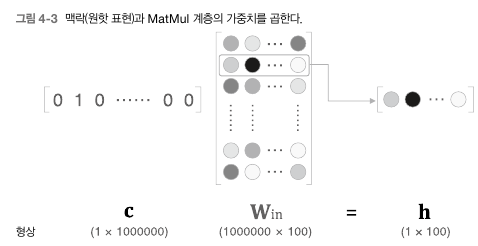

In [ ]:
import numpy as np

class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        # add.at이라는 점에 주목!
        np.add.at(dW, self.idx, dout)
        return None

$W$에서 단어를 추출한다는게(순전파) 사실상 그 행렬에서 해당 행을 빼오는 것이므로, 순전파 적용은 쉽고. 이를 바탕으로 역전파는 해당 행(arr.)을 다시 $W$에 해당하는 행에 집어넣는 것이다.

만약에 역전파 과정에서 같은 행에 해당하는 두 arr.가 역전파를 시도하면 위의 식은 덮어씌워버린다. 이 문제를 해결하기 위해서 우리는 해당하는 행의 값에 더한다. 위의 코드에서는 `np.add.at()`을 사용해서 기존 행에 값을 더해준다.

---

다음으로 해결해야할 속도/병목문제는 2번째 레이어에서의 행렬곱과 뒤에 따르는 softmax함수의 행렬곱 계산이다.

다음 과정에서 $W$의 곱셈과 softmax부분이다.

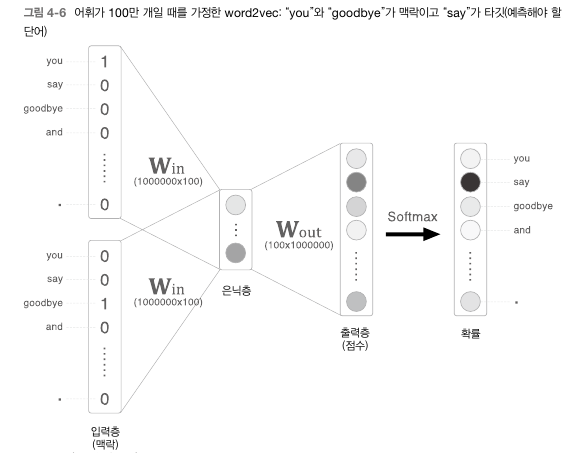

소프트맥스 함수또한 다음과 같으므로
$$
y_k = \frac{\exp(s_k)}{\sum_{i = 1}^{N}\exp(s_i)}
$$
여기서 N이 막 100만개, 1000만개가 된다면 각 단어별로 또 이걸 계산헤야하니 엄청난 양의 계산 시간이 걸릴 것이다.

일단 가장 계산 overhead가 큰 Softmax함수를 쓰는 다중분류 classification모델이라는 문제부터가 있다. 이를 이진분류로 만들 수 있다면 모델을 훨씬 가볍게 만들 수 있을 것이다.

어떻게 이진분류를 이거 만드느냐면:
$$
\text{A와 B 사이에 C-X단어가 들어갈 확률} \to \text{A와 B 사이에 C가 들어갈 수 있나?}
$$

단어 하나만을 타겟으로 모델을 만든다면, 우리는 출력층 레이어 노드를 딱 하나만 사용할 수 있다.

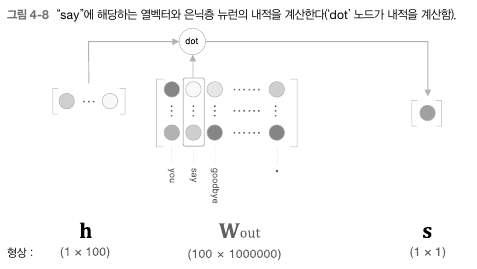

단순 이진분류 문제이므로 최종 레이어는 시그모이드 한개를 보통 쓰고 역전파시에는 교차 엔트로피 오류를 사용해서 training을 한다.

초기에 배웠듯이 시그모이드 함수는 x가 커지면 1에 근접하고, 작아지면 0에 근접하는 함수이다. 이 특성때문에 이진분류에 쓰기가 쉬운 함수 중 하나.

앞서 softmax with Loss만들었을 때 처럼, sigmoid함수도 sigmoid with Loss를 통해서 만들 수 있다.

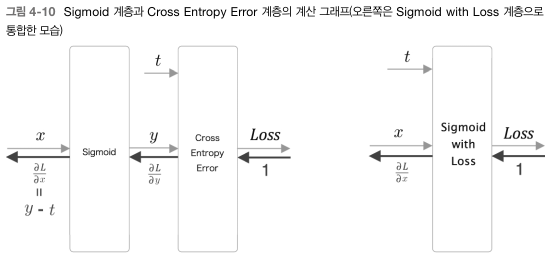

위 그림에서 주목할 점 중 하나가 $y-t$인데, y가 여기서는 prediction이고 t가 true label임. 뭐 당연하지만 t에 대한 y의 오차가 클수록 학습률이 증가한다는 의미. 차피 라벨은 하나이니 단순이 빼는것만으로도 오차를 알 수 있다.

---

이제 앞에서 다룬 2가지 방식을 적용해서 CBOW를 구현해본다면 다음과같다.

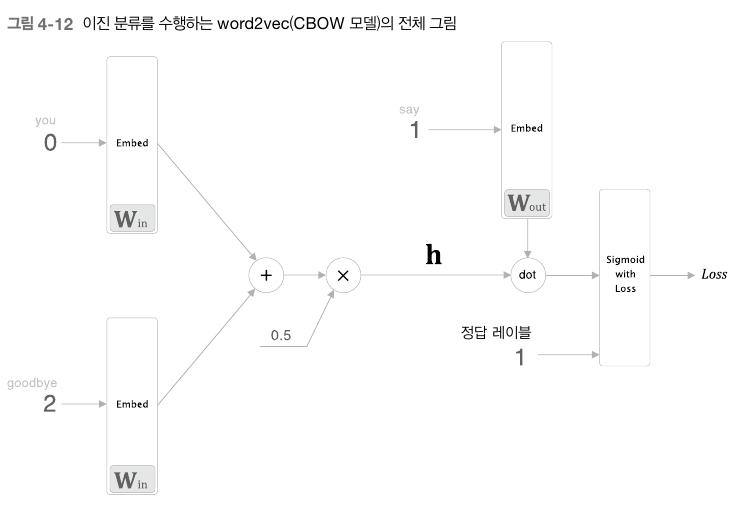

In [ ]:
class EmbeddingDot:
    def __init__(self, W) -> None:
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
    
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

---

훈련을 진행할 때 알아둬야할 것 중 하나가 바로 모두 다 긍정적 예시일 경우만 하면 안된다는 것이다. 다 긍정적 예시로 했다가는 모든 단어들보고 다 들어갈 수 있다고 판별할 수 있기 때문이다. 부정적 예시또한 같은 형식이다.

그러므로 긍정적 예시에 부정적 예시도 적당히 섞은 데이터셋에서 학습하는것이 좋다. 관례적으로는 대부분 긍정적 데이터에 약간의 부정적 예시를 넣어서 학습한다.

무작위로 샘플링하거나 하나하나 확인해서 학습데이터에 넣어주는거보다 corpus안에 있는 단어들의 통계를 통해서 샘플링하는 기법이 가장 좋다.

단어의 빈도에 비례하여 샘플링을 하는 것이다. 빈도가 잦은 단어가 들어맞을 가능성이 높고, 희귀한 단어들은 잘 들어맞지 않기에 되는 원리이다.

이 방식을 네거티브 샘플링이라고 한다. 코드로 구현을 한다면, `np.random.choice`를 사용할 수 있다.

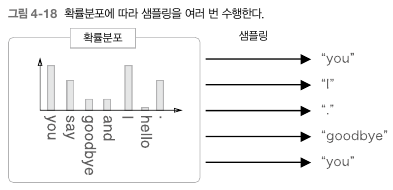

그런데 계산할때는 우리가 각 빈도에다가 0.75승을 해주게 된다. 이거 하는 이유가 높은 확률은 조금 낮춰주고 낮은 값들은 조금 키워주는 역할을 해서 조금 더 진도의 "공평함"을 주기 위해서이다.

In [5]:
import sys
sys.path.append('..')
import collections
from common.np import *
from common.layers import Embedding, SigmoidWithLoss

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None
        
        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1
            
        vocab_size = len(counts)
        self.vocab_size = vocab_size
        
        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]
            
        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)
        
    def get_negative_sample(self, target):
        batch_size = target.shape[0]
        
        if not GPU:  # == CPU
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)
            
            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0  # target이 뽑히지 않게 하기 위함
                p /= p.sum()  # 다시 정규화 해줌
                negative_sample[i, :] = np.random.choice(self.vocab_size,
                                                         size=self.sample_size,
                                                         replace=False, p=p)
                
        else:
            # GPU(cupy)로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, 
                                               size=(batch_size, self.sample_size), 
                                               replace=True, p=self.word_p)
            
        return negative_sample


class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size 
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]  # embed_dot에 해당하는 타겟이라는 의미인 듯
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        
        return dh

# Chap04/negative_sampling_layer.py
import sys
sys.path.append('..')
import collections
from common.np import *
from common.layers import Embedding, SigmoidWithLoss

class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh


class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None
        
        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1
            
        vocab_size = len(counts)
        self.vocab_size = vocab_size
        
        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]
            
        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)
        
    def get_negative_sample(self, target):
        batch_size = target.shape[0]
        
        if not GPU:  # == CPU
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)
            
            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0  # target이 뽑히지 않게 하기 위함
                p /= p.sum()  # 다시 정규화 해줌
                negative_sample[i, :] = np.random.choice(self.vocab_size,
                                                         size=self.sample_size,
                                                         replace=False, p=p)
                
        else:
            # GPU(cupy)로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, 
                                               size=(batch_size, self.sample_size), 
                                               replace=True, p=self.word_p)
            
        return negative_sample


class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size 
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]  # embed_dot에 해당하는 타겟이라는 의미인 듯
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        
        return dh

---

개선 CBOW모델 구현

In [7]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        # 레이어 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)  # average
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

In [10]:
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.layers import *

class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # 계층 생성
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None

# ================================================================

from common import config

config.GPU = False

import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

In [11]:
# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

In [12]:
# 모델 등 생성
model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [13]:
# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size, eval_interval=2000)
trainer.plot()

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 41.59


KeyboardInterrupt: 